# Modeling Crop Yield
## Python modules

In [1]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date

import numpy as np
import pandas as pd
import geopandas
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr

In [2]:
country_shp = geopandas.read_file(here('data', 'geo_boundaries', 'gadm36_ZMB_2.shp'))
country_shp = country_shp.set_index('district')

crop_df = pd.read_csv(here('data', 'crop_yield', 'cfs_maize_districts_zambia_2009_2022.csv'))
crop_df = crop_df.set_index(['district', 'year'])[['yield_mt']]
                             
weights_4_fn = 'ZMB_cropland_percentage_4k-points.feather'
weights_15_fn = 'ZMB_cropland_percentage_15k-points.feather'
weights_20_fn = 'ZMB_cropland_percentage_20k-points.feather'
  
weights_4 = pd.read_feather(here("data", "land_cover", weights_4_fn))
weights_15 = pd.read_feather(here("data", "land_cover", weights_15_fn))
weights_20 = pd.read_feather(here("data", "land_cover", weights_20_fn))
                           
weights_4.lon, weights_4.lat = round(weights_4.lon, 5), round(weights_4.lat, 5)
weights_15.lon, weights_15.lat = round(weights_15.lon, 5), round(weights_15.lat, 5)
weights_20.lon, weights_20.lat = round(weights_20.lon, 5), round(weights_20.lat, 5)

In [3]:
def get_merged_files(flist, **kwargs):
    return pd.concat([pd.read_feather(f, **kwargs) for f in flist], axis=0).reset_index(drop=True)

def merge_tuple(x, bases = (tuple, list)):
    for e in x:
        if type(e) in bases:
            for e in merge_tuple(e, bases):
                yield e
        else:
            yield e

In [4]:
file_groups = pd.DataFrame()
satellites = ["sentinel-2-l2a","landsat-8-c2-l2","landsat-c2-l2"]
for satellite in satellites:
    
    directory = here("data", "random_features", satellite)
    files = os.listdir(directory)
    files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
    files.sort()
    
    for file in files:
        f = file.split(sep="_")
        d = {
            'satellite'    : f[0],
            'bands'        : f[1].replace("bands-", ""),
            'country_code' : f[2],
            'points'       : int(f[3].replace("k-points", "")),
            'num_features' : f[4].replace("-features", ""),
            'pattern'      : f[0]+'_'+f[1]+'_'+f[2]+'_'+f[3]+'_'+f[4]+'_*'
        }
        df = pd.DataFrame(data=d, index=[0])
        file_groups = pd.concat([file_groups, df])
        
file_groups = file_groups.sort_values(by=['points'], ascending=True)
file_groups = file_groups.drop_duplicates().reset_index(drop=True)
file_groups

,satellite,bands,country_code,points,num_features,pattern
0,sentinel-2-l2a,2-3-4,ZMB,4,1000,sentinel-2-l2a_bands-2-3-4_ZMB_4k-points_1000-...
1,landsat-8-c2-l2,1-2-3-4-5-6-7,ZMB,15,1000,landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-po...
2,sentinel-2-l2a,2-3-4-8,ZMB,15,1000,sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_10...
3,sentinel-2-l2a,2-3-4,ZMB,15,1000,sentinel-2-l2a_bands-2-3-4_ZMB_15k-points_1000...
4,landsat-c2-l2,r-g-b-nir-swir16-swir22,ZMB,20,1024,landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZM...
5,landsat-8-c2-l2,1-2-3-4-5-6-7,ZMB,20,1000,landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-po...
6,sentinel-2-l2a,2-3-4,ZMB,20,1000,sentinel-2-l2a_bands-2-3-4_ZMB_20k-points_1000...


In [5]:
file_groups = file_groups[file_groups.satellite == "sentinel-2-l2a"]
file_groups = file_groups[file_groups.points == 15]
file_groups = file_groups[file_groups.bands == '2-3-4-8']
file_groups

,satellite,bands,country_code,points,num_features,pattern
2,sentinel-2-l2a,2-3-4-8,ZMB,15,1000,sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_10...


In [6]:
names = 'limit_months crop_mask'.split()
paramlist = list(itertools.product([False,True], repeat = len(names)))
paramlist = list(itertools.product(file_groups.pattern.to_list(), paramlist))
for i in range(len(paramlist)):
    paramlist[i] = tuple(merge_tuple(paramlist[i]))
paramlist = [t for t in paramlist if (t[1] == False) & (t[2] == True)][0]
paramlist

('sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_*', False, True)

In [29]:
# f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_*' #'  yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'  
# paramlist = (f1, True, False, False)

# f1 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_*' #'yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'         
# paramlist = (f1, False, True, False)

# f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_*' #'yr-2014-2021_mn-1-12_lm-False_cm-False_wa-True_summary.feather'
# paramlist = (f1, False, False, True)

# f1 = 'sentinel-2-l2a_bands-2-3-4_ZMB_15k-points_1000-features_*' #'yr-2016-2022_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
# paramlist = (f1, True, False, False)

# f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_*' #'yr-2014-2021_mn-1-12_lm-False_cm-True_wa-True_summary.feather'
# paramlist = (f1, False, True, True)

f1 = 'sentinel-2-l2a_bands-2-3-4_ZMB_20k-points_1000-features_*' #'yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'
paramlist = (f1, False, True, False)

paramlist

('sentinel-2-l2a_bands-2-3-4_ZMB_20k-points_1000-features_*',
 False,
 True,
 False)

In [30]:
def impute_features(params):
    file         = params[0]
    limit_months = params[1]
    crop_mask    = params[2]
    # weighted_avg = params[3]
    f            = file.split(sep="_")
    satellite    = f[0]
    points       = int(f[3].replace("k-points", ""))
    num_features = int(f[4].replace("-features", ""))
 
    path = str(here("data", "random_features", satellite, file))
    files = glob.glob(pathname=path)
    
    print('Opening')
    
    features = get_merged_files(files)

    year_end = max(features.year)
    
    if satellite == "landsat-c2-l2":
        year_start = 2008
    elif satellite == "landsat-8-c2-l2":
        year_start = 2013 
    else:
        year_start = 2015 
        
    month_range = range(4, 10) if limit_months else range(1, 13)

    if (satellite == "landsat-8-c2-l2") & (limit_months):
        month_start = 4
    else:
        month_start = 10

    keep = np.where(
        ((features.year == year_start) & (features.month >= month_start)) | (features.year > year_start), True, False)

    features = features[keep]

    features['year'] = np.where(
        features['month'].isin([10, 11, 12]),
        features['year'] + 1, 
        features['year']
    )
    features = features[features.year <= year_end]

    features.lon, features.lat = round(features.lon, 5), round(features.lat, 5)

    features = features[features.month.isin(month_range)]

    features = features.set_index(['lon','lat', "year", 'month']).unstack()
    features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.reset_index(inplace = True)

    if points == 4:
        weights = weights_4.copy()
    elif points == 15:
        weights = weights_15.copy()
    elif points == 20:
        weights = weights_20.copy()

    features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])

    if crop_mask:
        features = features[features.crop_perc > 0]
    else:
        pass   

    features = geopandas.GeoDataFrame(
        features, 
        geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
        crs='EPSG:4326'
    )

    features = (
        features
        .sjoin(country_shp, how = 'left', predicate = 'within')
        .drop(['geometry'], axis = 1)
        .rename(columns = {"index_right": "district"})
        .dropna(subset=['district'])
        .reset_index(drop = True)
    )

    print('Imputing')
    
    num_cells = len(features) * len(month_range) * int(num_features)
    ln_ft = len(features); ln_na = len(features.dropna())
    features.fillna(features.groupby(['year', 'district'], as_index=False).transform('mean'), inplace=True)

    ln_ft = len(features); ln_na = len(features.dropna())
    features.fillna(features.groupby(['district'], as_index=False).transform('mean'), inplace=True)

    ln_ft = len(features); ln_na = len(features.dropna())
    features = features.dropna(axis=0)

    min_yr = min(features.year); max_yr = max(features.year)
    min_mn = min(month_range);   max_mn = max(month_range)

    f = f'{file[:-1]}yr-{min_yr}-{max_yr}_mn-{min_mn}-{max_mn}_lm-{limit_months}'+\
        f'_cm-{crop_mask}_full.feather'
    full_file = here('data', 'random_features', 'full_files', f)

    print('Saving')
    
    features.reset_index(drop=True).to_feather(full_file)

In [31]:
%%time
impute_features(paramlist)

Opening
Imputing
Saving
CPU times: user 11min 34s, sys: 4min 14s, total: 15min 48s
Wall time: 13min 53s


## Load the "best" model

In [66]:
hot_encode = True
weighted_avg = False
# file_suffix = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-True'
# model_fn_suffix = f'{file_suffix}_wa-{weighted_avg}_he-{hot_encode}'

file_suffix_1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False'
file_suffix_2 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True'
model_fn_suffix = f'best-k-fold-2-sensor-params_he-{True}'

k_model_fn = f'k-fold-cv_rr-model_{model_fn_suffix}.pkl'
logo_model_fn = f'logo-cv_rr-model_{model_fn_suffix}.pkl'
       
with open(here('models', k_model_fn), 'rb') as f:
    best_kfold_model = pickle.load(f)

In [ ]:
high_res_f_1 = f'{file_suffix_1}_full.feather'
high_res_fn_1 = here('data', 'random_features', 'full_files', high_res_f_1)
high_res_features_1 = pd.read_feather(high_res_fn_1)

high_res_f_2 = f'{file_suffix_2}_full.feather'
high_res_fn_2 = here('data', 'random_features', 'full_files', high_res_f_2)
high_res_features_2 = pd.read_feather(high_res_fn_2)

index_cols = ['district', 'year', 'crop_perc', 'lon', 'lat']
    
high_res_features_1 = high_res_features_1.set_index(index_cols).add_prefix("f1_")
high_res_features_2 = high_res_features_2.set_index(index_cols).add_prefix("f2_")

high_res_features = high_res_features_1.join(high_res_features_2).reset_index()
high_res_features = high_res_features[~high_res_features.isna().any(axis = 1)]

drop_cols = ['year', 'lon', 'lat', 'crop_perc', 'district']

if weighted_avg:
    high_res_features = high_res_features.set_index(drop_cols)
    high_res_features.rename(columns={x:y for x,y in zip(high_res_features.columns,range(0,len(high_res_features.columns)))}, inplace=True)
    high_res_features = high_res_features.reset_index()
    high_res_features.columns = high_res_features.columns.astype(str)

if hot_encode:
    drop_cols.remove('district')
    high_res_features = pd.get_dummies(high_res_features, columns=["district"], drop_first=False)
else:
    pass

high_res_predictions = high_res_features.copy()[drop_cols]

high_res_x_all = high_res_features.drop(drop_cols, axis = 1) 
high_res_predictions['prediction'] = best_kfold_model.predict(high_res_x_all)
high_res_predictions.reset_index(drop=True, inplace=True)

high_res_f_pred = f'high-res-pred_k-fold-cv_{model_fn_suffix}.feather'
high_res_fn_pred = here('data', 'results', high_res_f_pred)
high_res_predictions.to_feather(str(high_res_fn_pred))

In [31]:
hot_encode = True
f1 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-True_summary.feather'
f2 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-True_wa-True_summary.feather'
logo_prefix = 'logo-cv'
kfold_prefix = 'logo-cv'
model_fn_suffix = 'fn-1_sentinel-2-l2a_2-3-4-8_15_False_True_True_fn-2_landsat-8-c2-l2_1-2-3-4-5-6-7_20_True_True_True_True_he-True'
logo_f = f'{logo_prefix}_rr-model_{model_fn_suffix}.pkl'
kfold_f = f'{kfold_prefix}_rr-model_{model_fn_suffix}.pkl'

with open(here('models', kfold_f), 'rb') as f:
    best_kfold_model = pickle.load(f)
    
with open(here('models', logo_f), 'rb') as f:
    best_logo_model = pickle.load(f)

# f1 = f'{file_suffix_1}_wa-{weighted_avg}_summary.feather'
# f2 = f'{file_suffix_2}_wa-{weighted_avg}_summary.feather'

features_1 = pd.read_feather(here('data', 'random_features', 'summary', f1))
features_2 = pd.read_feather(here('data', 'random_features', 'summary', f2))

#########################################     CLEAN DATA    #########################################  
min_year = max(min(features_1.year), min(features_2.year))
max_year = min(max(features_1.year), max(features_2.year))

features_1 = features_1[features_1.year >= min_year]
features_2 = features_2[features_2.year >= min_year]

features_1 = features_1[features_1.year <= max_year]
features_2 = features_2[features_2.year <= max_year]

features_1.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
features_2.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

index_cols = ['district', 'year', 'yield_mt']

features_1 = features_1.set_index(index_cols).add_prefix("f1_")
features_2 = features_2.set_index(index_cols).add_prefix("f2_")

#########################################     JOIN DATA    #########################################  
features = features_1.join(features_2).reset_index()

features = features[~features.isna().any(axis = 1)].reset_index(drop=True)

summary_predictions = features.copy().loc[:, tuple(index_cols)].reset_index(drop=True)

if hot_encode:
    index_cols.remove('district')
    features = pd.get_dummies(features, columns = ["district"], drop_first = False)
else:
    pass

#########################################     SPLIT DATA    #########################################
x_all = features.drop(index_cols, axis=1)
x_all = StandardScaler().fit_transform(x_all)
x_all = pd.DataFrame(x_all)
y_all = np.log10(features.yield_mt.to_numpy() + 1)
g_all = features.year.ravel()

x_train, x_test,\
y_train, y_test,\
g_train, g_test = train_test_split(x_all, y_all, g_all, test_size = 0.2, random_state = 0)

kfold = KFold()
logo = LeaveOneGroupOut()

kfold_cv_predictions = cross_val_predict(best_kfold_model, X = x_train, y = y_train, cv=kfold)
logo_cv_predictions  = cross_val_predict(best_logo_model, X = x_all, y = y_all, groups = g_all,  cv = logo)

x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
x_train['kfold_cv_predictions'] = kfold_cv_predictions
x_train['split'], x_test['split'] = 'train', 'test'

train_test = pd.concat([x_train, x_test])[['split','kfold_cv_predictions']]

summary_predictions['log_yield'] = y_all
summary_predictions['prediction'] = np.maximum(best_kfold_model.predict(x_all), 0)

summary_predictions = summary_predictions.join(train_test)
summary_predictions['logo_cv_predictions'] = logo_cv_predictions
summary_predictions['logo_prediction'] = np.maximum(best_logo_model.predict(x_all), 0) #best_logo_model.predict(x_all)

summary_f_pred = f'summary-pred_{model_fn_suffix}.csv'
summary_fn_pred = here('data', 'results', summary_f_pred)
summary_predictions.to_csv(summary_fn_pred, index=False)
summary_predictions

,district,year,yield_mt,log_yield,prediction,split,kfold_cv_predictions,logo_cv_predictions,logo_prediction
0,Chadiza,2016,1.876427,0.458853,0.458853,train,0.428154,0.350585,0.458853
1,Chadiza,2017,2.882947,0.589161,0.589161,test,NaN,0.436503,0.589161
2,Chadiza,2018,1.299279,0.361592,0.361592,train,0.461587,0.442388,0.361592
3,Chadiza,2019,2.131008,0.495684,0.495684,train,0.400254,0.509221,0.495684
4,Chadiza,2020,2.626538,0.559492,0.559492,test,NaN,0.692717,0.559492
...,...,...,...,...,...,...,...,...,...
415,Zambezi,2017,1.490456,0.396279,0.396279,train,0.453101,0.511513,0.396279
416,Zambezi,2018,1.622273,0.418678,0.418678,train,0.527699,0.486318,0.418678
417,Zambezi,2019,1.184923,0.339436,0.339436,train,0.459731,0.483137,0.339436
418,Zambezi,2020,1.689628,0.429692,0.429692,train,0.450185,0.589586,0.429692


In [26]:
r2_score(summary_predictions.log_yield, summary_predictions.logo_cv_predictions)

0.4309504419975837

In [27]:
r2_score(y_train, kfold_cv_predictions)

0.6573028866339572

In [28]:
r2_score(summary_predictions.log_yield, summary_predictions.logo_prediction)

1.0

In [29]:
r2_score(summary_predictions.log_yield, summary_predictions.prediction)

1.0

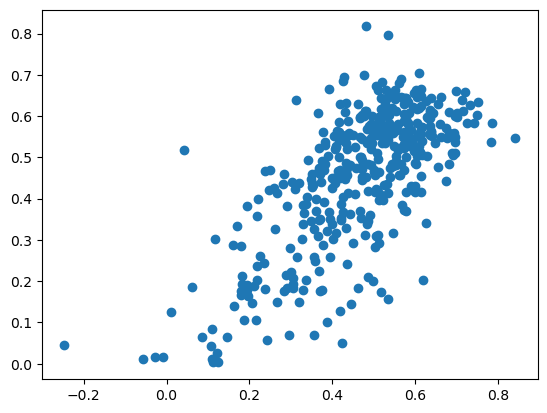

In [30]:
plt.scatter(summary_predictions.logo_cv_predictions, summary_predictions.log_yield)

## Make high resolution predictions

In [15]:
high_res_f = f'{file_suffix}_full.feather'
high_res_fn = here('data', 'random_features', 'full_files', high_res_f)
high_res_features = pd.read_feather(high_res_fn)

drop_cols = ['year', 'lon', 'lat', 'crop_perc', 'district']

if weighted_avg:
    high_res_features = high_res_features.set_index(drop_cols)
    high_res_features.rename(columns={x:y for x,y in zip(high_res_features.columns,range(0,len(high_res_features.columns)))}, inplace=True)
    high_res_features = high_res_features.reset_index()
    high_res_features.columns = high_res_features.columns.astype(str)

if hot_encode:
    drop_cols.remove('district')
    high_res_features = pd.get_dummies(high_res_features, columns=["district"], drop_first=False)
else:
    pass

high_res_predictions = high_res_features.copy()[drop_cols]

high_res_x_all = high_res_features.drop(drop_cols, axis = 1) 
high_res_predictions['prediction'] = np.maximum(best_kfold_model.predict(high_res_x_all), 0)

high_res_f_pred = f'high-res-pred_k-fold-cv_{model_fn_suffix}.feather'
high_res_fn_pred = here('data', 'results', high_res_f_pred)
high_res_predictions.to_feather(str(high_res_fn_pred))

## Make summary predictions

In [16]:
summary_f = f'{file_suffix}_wa-{weighted_avg}_summary.feather'
summary_fn = here('data', 'random_features', 'summary', summary_f)
summary_features = pd.read_feather(summary_fn)

In [17]:
drop_cols = ['district', 'year', 'yield_mt']
summary_predictions = summary_features.copy().loc[:, tuple(drop_cols)]

if hot_encode:
    drop_cols.remove("district")
    summary_features = pd.get_dummies(summary_features, columns=["district"], drop_first=False)
else:
    pass

summary_x_all = summary_features.drop(drop_cols, axis = 1) 
summary_y_all = np.log10(summary_features.yield_mt.to_numpy() + 1)
summary_predictions['log_yield'] = summary_y_all
summary_predictions['prediction'] = best_kfold_model.predict(summary_x_all)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    summary_x_all, summary_y_all, test_size = 0.2, random_state = 0)

In [19]:
kfold = KFold()
x_train['kfold_cv_predictions'] = cross_val_predict(best_kfold_model, X = x_train, y = y_train, cv=kfold)
x_train['split'], x_test['split']= 'train', 'test'
train_test = pd.concat([x_train, x_test])[['split', 'kfold_cv_predictions']]
summary_predictions = summary_predictions.join(train_test)

In [20]:
summary_f_pred = f'summary-pred_k-fold-cv_{model_fn_suffix}.csv'
summary_fn_pred = here('data', 'results', summary_f_pred)
summary_predictions.to_csv(summary_fn_pred, index=False)

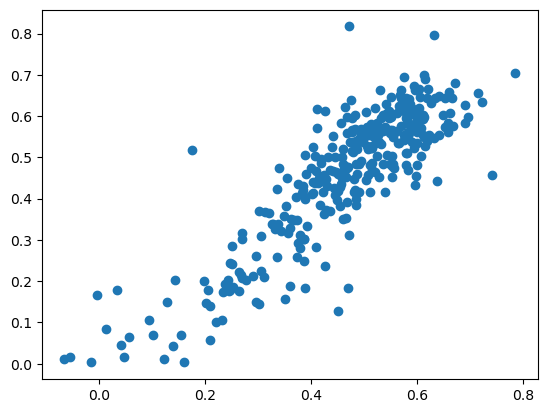

In [121]:
plt.scatter(x_train.kfold_cv_predictions, y_train)

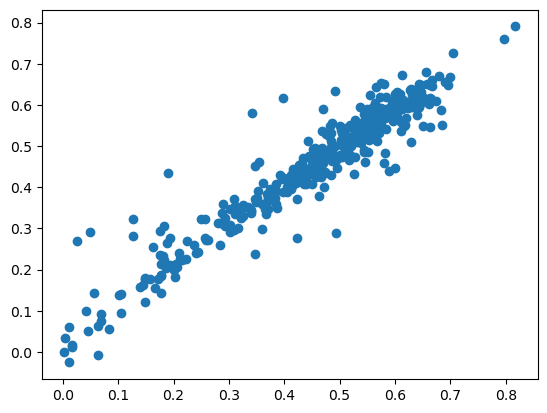

In [122]:
plt.scatter(summary_predictions.log_yield, summary_predictions.prediction)